<a href="https://colab.research.google.com/github/daryaami/ML-for-Scientific-Data-Analysis-Course/blob/hometask_2/Task2_Advanced_models_and_interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Датасет для прогнозирования болезней сердца

### Context

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

### Description
* Age: age of the patient [years]
* Sex: sex of the patient [M: Male, F: Female]
* ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* RestingBP: resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
* Oldpeak: oldpeak = ST [Numeric value measured in depression]
* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* HeartDisease: output class [1: heart disease, 0: Normal] **TARGET**




## Импорт

In [ ]:
!pip install category_encoders > None
!pip install shap > None

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

import shap

import warnings
warnings.simplefilter('ignore')

## Preprocessing

In [ ]:
data = pd.read_csv('heart.csv')
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Бинарные признаки можно закодировать Label Encoder'ом. Признаки с уникальными значениями более двух можно закодировать One Hot или Binary Encoder

Label Encoding

In [ ]:
cols_for_le = ['Sex', 'ExerciseAngina']

In [ ]:
for col in cols_for_le:
    le = LabelEncoder()
    data[col + '_encoded'] = le.fit_transform(data[col])
    print(le.classes_)

data = data.drop(columns=cols_for_le)

['F' 'M']
['N' 'Y']


One Hot Encoding

In [ ]:
cols_for_ooh = ['RestingECG']

In [ ]:
for col in cols_for_ooh:
    encoded_data = pd.get_dummies(data[col], prefix=col)
    data = pd.concat([data, encoded_data], axis=1)

data = data.drop(columns=cols_for_ooh)

Binary Encoding

In [ ]:
cols_for_be = ['ChestPainType']
be = BinaryEncoder(cols=cols_for_be)
data = be.fit_transform(data)
be.get_feature_names_out()

array(['Age', 'ChestPainType_0', 'ChestPainType_1', 'ChestPainType_2',
       'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'ST_Slope', 'HeartDisease', 'Sex_encoded',
       'ExerciseAngina_encoded', 'RestingECG_LVH', 'RestingECG_Normal',
       'RestingECG_ST'], dtype=object)

ST_Slope можно закодировать с помощью метода map, так как есть явная полярность значений

In [ ]:
data['ST_Slope'] = data['ST_Slope'].map({'Down': 1, 'Flat': 0, 'Up': -1})

In [ ]:
data.describe()

,Age,ChestPainType_0,ChestPainType_1,ChestPainType_2,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ST_Slope,HeartDisease,Sex_encoded,ExerciseAngina_encoded,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.050109,0.761438,0.728758,132.396514,198.799564,0.233115,136.809368,0.887364,-0.361656,0.553377,0.789760,0.404139,0.204793,0.601307,0.193900
std,9.432617,0.218289,0.426437,0.444843,18.514154,109.384145,0.423046,25.460334,1.066570,0.607056,0.497414,0.407701,0.490992,0.403770,0.489896,0.395567
min,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,0.000000,1.000000,0.000000,120.000000,173.250000,0.000000,120.000000,0.000000,-1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,0.000000,1.000000,1.000000,130.000000,223.000000,0.000000,138.000000,0.600000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,60.000000,0.000000,1.000000,1.000000,140.000000,267.000000,0.000000,156.000000,1.500000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,77.000000,1.000000,1.000000,1.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
data = data.drop('Cholesterol', axis=1)

## Models

In [ ]:
data.head()

,Age,ChestPainType_0,ChestPainType_1,ChestPainType_2,RestingBP,FastingBS,MaxHR,Oldpeak,ST_Slope,HeartDisease,Sex_encoded,ExerciseAngina_encoded,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
0,40,0,0,1,140,0,172,0.0,-1,0,1,0,0,1,0
1,49,0,1,0,160,0,156,1.0,0,1,0,0,0,1,0
2,37,0,0,1,130,0,98,0.0,-1,0,1,0,0,0,1
3,48,0,1,1,138,0,108,1.5,0,1,0,1,0,1,0
4,54,0,1,0,150,0,122,0.0,-1,0,1,0,0,1,0


In [ ]:
X, y = data.drop(['HeartDisease'], axis=1), data['HeartDisease']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=22,
                                                    test_size=0.2,
                                                    stratify=y)

In [ ]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train.columns
)

### Простая логистическая регрессия
Возьмем этот результат за бенчмарк

In [ ]:
def evaluate(predictions):
    print(classification_report(y_test, predictions, digits=4))
    print("f1_score: ", f1_score(y_test, predictions))

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(random_state=22))])
pipeline.fit(X_train_scaled, y_train)
predictions = pipeline.predict(X_test_scaled)

evaluate(predictions)

              precision    recall  f1-score   support

           0     0.8148    0.8049    0.8098        82
           1     0.8447    0.8529    0.8488       102

    accuracy                         0.8315       184
   macro avg     0.8297    0.8289    0.8293       184
weighted avg     0.8314    0.8315    0.8314       184

f1_score:  0.848780487804878


### Ridge

Попробуем использовать ограничения на рост коэффициентов и первично оценить их важность.

In [ ]:
ridge = RidgeClassifier(alpha=1)
ridge.fit(X_train_scaled, y_train)
y_preds = ridge.predict(X_test_scaled)

evaluate(y_preds)

              precision    recall  f1-score   support

           0     0.8171    0.8171    0.8171        82
           1     0.8529    0.8529    0.8529       102

    accuracy                         0.8370       184
   macro avg     0.8350    0.8350    0.8350       184
weighted avg     0.8370    0.8370    0.8370       184

f1_score:  0.8529411764705882


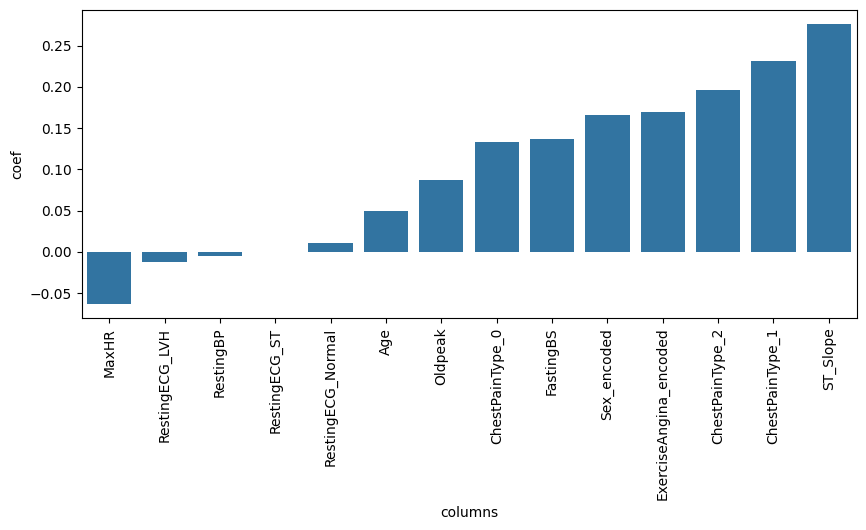

In [ ]:
ridge_coef_df = pd.DataFrame({'columns': X_train_scaled.columns, 'coef': ridge.coef_[0]}).sort_values(by='coef')
plt.figure(figsize=(10,4))
sns.barplot(x=ridge_coef_df['columns'], y=ridge_coef_df['coef'])
plt.xticks(rotation=90)
plt.show()

### Bagging & Optimization

In [ ]:
bagging_model = BaggingClassifier(
    base_estimator=LogisticRegression(),
    n_estimators=200,
    random_state=24,
)

bagging_model.fit(X_train_scaled, y_train)

bagging_preds = bagging_model.predict(X_test_scaled)

evaluate(bagging_preds)

              precision    recall  f1-score   support

           0     0.8250    0.8049    0.8148        82
           1     0.8462    0.8627    0.8544       102

    accuracy                         0.8370       184
   macro avg     0.8356    0.8338    0.8346       184
weighted avg     0.8367    0.8370    0.8367       184

f1_score:  0.854368932038835


Для оптимизации гиперпараметров применим RandomizedSearchCV

In [ ]:
parameters = {
    'n_estimators': np.arange(10, 200, 20),
    'max_samples': np.arange(0.1, 1, 0.1),
    'max_features': np.arange(0.1, 1, 0.1),
    'random_state': [24],
}

bagging_random_search = RandomizedSearchCV(
    estimator=BaggingClassifier(),
    param_distributions=parameters,
    n_iter=20,
    n_jobs=2,
    random_state=24,
    verbose=1
)

bagging_random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(estimator=BaggingClassifier(), n_iter=20, n_jobs=2,
                   param_distributions={'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'max_samples': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'n_estimators': array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190]),
                                        'random_state': [24]},
                   random_state=24, verbose=1)

In [ ]:
bagging_random_search.best_params_

{'random_state': 24,
 'n_estimators': 130,
 'max_samples': 0.6,
 'max_features': 0.6}

In [ ]:
bagging_predictions = bagging_random_search.best_estimator_.predict(X_test_scaled)
evaluate(bagging_predictions)

              precision    recall  f1-score   support

           0     0.8750    0.7683    0.8182        82
           1     0.8304    0.9118    0.8692       102

    accuracy                         0.8478       184
   macro avg     0.8527    0.8400    0.8437       184
weighted avg     0.8503    0.8478    0.8464       184

f1_score:  0.8691588785046729


Чтобы найти лучшие параметры за ограниченное время, попробуем HalvingRandomSearch

In [ ]:
clf = BaggingClassifier()

parameters = {
    'n_estimators': np.arange(10, 200, 20),
    'max_samples': np.arange(0.1, 1, 0.1),
    'max_features': np.arange(0.1, 1, 0.1),
    'random_state': [24],
}

bagging_halving_search = HalvingRandomSearchCV(
    estimator=clf,
    param_distributions=parameters,
    factor=4,
    n_jobs=2,
    random_state=24,
    verbose=1,
)
bagging_halving_search.fit(X_train_scaled, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 734
aggressive_elimination: False
factor: 4
----------
iter: 0
n_candidates: 36
n_resources: 20
Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------
iter: 1
n_candidates: 9
n_resources: 80
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 2
n_candidates: 3
n_resources: 320
Fitting 5 folds for each of 3 candidates, totalling 15 fits


HalvingRandomSearchCV(estimator=BaggingClassifier(), factor=4, n_jobs=2,
                      param_distributions={'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                           'max_samples': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                           'n_estimators': array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190]),
                                           'random_state': [24]},
                      random_state=24, verbose=1)

In [ ]:
bagging_halving_search.best_params_

{'random_state': 24,
 'n_estimators': 150,
 'max_samples': 0.6,
 'max_features': 0.7000000000000001}

In [ ]:
bagging_preds = bagging_halving_search.predict(X_test_scaled)

evaluate(bagging_preds)

              precision    recall  f1-score   support

           0     0.8784    0.7927    0.8333        82
           1     0.8455    0.9118    0.8774       102

    accuracy                         0.8587       184
   macro avg     0.8619    0.8522    0.8553       184
weighted avg     0.8601    0.8587    0.8577       184

f1_score:  0.8773584905660377


Оптимизация действительно нашла параметры, которые улучшают точность нашей модели

### Random Forest

In [ ]:
parameters = {
    'n_estimators': np.arange(50, 100, 20),
    # 'criterion': ['gini', 'entropy'],
    'max_depth': list(range(3, 11)) + [None],
    'random_state': [24],
}

rf_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=parameters,
    n_jobs=2,
    verbose=1,
    cv=3,
)

In [ ]:
rf_search.fit(X_train_scaled, y_train)

best_parameters = rf_search.best_params_
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
max_depth: 8
n_estimators: 70
random_state: 24


In [558]:
rf_preds = rf_search.best_estimator_.predict(X_test_scaled)
evaluate(rf_preds)

              precision    recall  f1-score   support

           0     0.8608    0.8293    0.8447        82
           1     0.8667    0.8922    0.8792       102

    accuracy                         0.8641       184
   macro avg     0.8637    0.8607    0.8620       184
weighted avg     0.8640    0.8641    0.8638       184

f1_score:  0.8792270531400966


Случайный лес дал еще большую точность

### XGBoost

In [ ]:
clf = XGBClassifier()
parameters = {
  'learning_rate': np.linspace(0.01, 2, 10),
  'max_depth': list(range(3, 11)) + [None],
  'subsample': np.linspace(0.2, 0.98, 10),
  'colsample_bytree': np.linspace(0.2, 0.98, 10),
  'n_estimators': np.arange(50, 300, 10),
  'seed': [24]
}

xgb_random_search = RandomizedSearchCV(
    clf,
    parameters,
    n_jobs=5,
    cv=5,
    verbose=2,
    random_state=24,
    refit=True
)
xgb_random_search.fit(X_train_scaled, y_train)

xgb_random_search.best_params_

In [559]:
xgb_preds = xgb_random_search.best_estimator_.predict(X_test_scaled)

evaluate(xgb_preds)

              precision    recall  f1-score   support

           0     0.8442    0.7927    0.8176        82
           1     0.8411    0.8824    0.8612       102

    accuracy                         0.8424       184
   macro avg     0.8426    0.8375    0.8394       184
weighted avg     0.8425    0.8424    0.8418       184

f1_score:  0.861244019138756


### Интерпретация

Так как лучшее качество дал алгоритм Случайного леса, рассморим его коэффициенты

In [560]:
rf = rf_search.best_estimator_
rf

RandomForestClassifier(max_depth=8, n_estimators=70, random_state=24)

Permutation importances

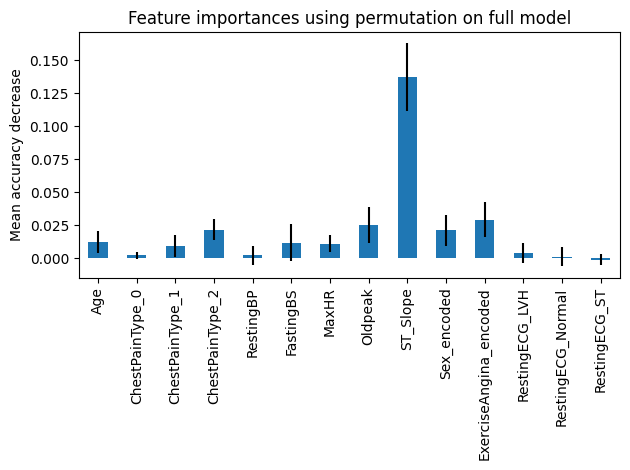

In [ ]:
importances = permutation_importance(rf, X_test_scaled, y_test, n_repeats=10, random_state=24, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

График показывает, что при перемешивании значениий некоторых параметров качество модели почти не меняется. Самые незначимые признаки в наборе - RestingECG (все категории), RestingBP

SHAP

Для наглядности рассмотрим три тестовых наблюдения с низкой, средней и высокой вероятностью принадлежности к целевому классу 1 (болезни сердца)

In [ ]:
Xtest = X_test.reset_index(drop=True)

In [563]:
low_instance = 90
Xtest.loc[[low_instance]]

,Age,ChestPainType_0,ChestPainType_1,ChestPainType_2,RestingBP,FastingBS,MaxHR,Oldpeak,ST_Slope,Sex_encoded,ExerciseAngina_encoded,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
90,39,0,0,1,120,0,145,0.0,-1,1,0,0,1,0


In [564]:
explainer = shap.TreeExplainer(rf)
choosen_instance = X_test_scaled.loc[[low_instance]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [565]:
medium_instance = 6
Xtest.loc[[medium_instance]]

,Age,ChestPainType_0,ChestPainType_1,ChestPainType_2,RestingBP,FastingBS,MaxHR,Oldpeak,ST_Slope,Sex_encoded,ExerciseAngina_encoded,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
6,45,1,0,0,110,0,132,1.2,0,1,0,0,1,0


In [566]:
choosen_instance = X_test_scaled.loc[[medium_instance]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [567]:
high_instance = 1
Xtest.loc[[high_instance]]

,Age,ChestPainType_0,ChestPainType_1,ChestPainType_2,RestingBP,FastingBS,MaxHR,Oldpeak,ST_Slope,Sex_encoded,ExerciseAngina_encoded,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
1,67,0,1,1,160,0,108,1.5,0,1,1,1,0,0


In [568]:
choosen_instance = X_test_scaled.loc[[high_instance]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

Можно заметить, что увеличение признака Возраст положительно влияет на целевую переменную, что логично. Также модель заметила зависимость целевой переменной от пола - мужской пол вызывает увеличение значения таргета. Это подтверждается статистикой - мужчины в среднем намного чаще страдают от болезней сердца. Также на увеличение "вероятности" болезней сердца положительно влияют такие признаки как ST_Slope (Наклон пикового сегмента на кардиограмме при нагрузке), ExerciseAngina (стенокардия, вызванная физической нагрузкой), FastingBS (Уровень сахара в крови натощак).


### Финальная оценка

In [ ]:
evaluate(rf.predict(X_test_scaled))

              precision    recall  f1-score   support

           0     0.8608    0.8293    0.8447        82
           1     0.8667    0.8922    0.8792       102

    accuracy                         0.8641       184
   macro avg     0.8637    0.8607    0.8620       184
weighted avg     0.8640    0.8641    0.8638       184

f1_score:  0.8792270531400966


Благодаря более сложным моделям МО удалось повысить метрику f1-score с 0.849 до 0.879. На выбранном датасете самую высокую точность показала модель RandomForestClassifier с подбором гиперпараметров путем GridSearch.

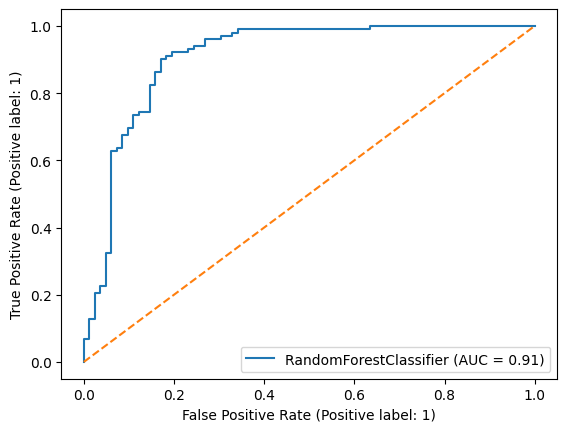

In [ ]:
RocCurveDisplay.from_estimator(rf, X_test_scaled, y_test)
plt.plot([0, 1], [0, 1], linestyle='dashed')
plt.show()